In [69]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from datetime import datetime
import pickle 
import matplotlib.pyplot as plt

path_to_mimic = '/mnt/c/Users/hhelm/Documents/Helivan/Data/physionet.org/files/mimiciv/2.2/'

path_to_chart_file = path_to_mimic + 'icu/chartevents.csv'
CHARTEVENTS = pd.read_csv(path_to_chart_file, sep=',', nrows=10000000)

path_to_items_file = path_to_mimic + 'icu/d_items.csv'
ITEMS = pd.read_csv(path_to_items_file, sep=',')

path_to_icu_file = path_to_mimic + 'icu/icustays.csv'
ICUSTAYS = pd.read_csv(path_to_icu_file, sep=',')

path_to_patients_file = path_to_mimic + 'hosp/patients.csv'
PATIENT_INFO = pd.read_csv(path_to_patients_file, sep=',')

path_to_admissions_file = path_to_mimic + 'hosp/admissions.csv'
ADMISSIONS_INFO = pd.read_csv(path_to_admissions_file, sep=',')

items_list = ['HR', 'RR', 'ABPm', 'NBPm', 'Temperature', 'FiO2']
items_list += ['Glucose (whole blood)', 'WBC', 'PAR-Respiration', 'PAR-Consciousness']

ITEM_TO_ABBR = {i: [i] for i in items_list}
ITEM_TO_ABBR['Temperature'] = ['Temperature C', 'Temperature F']

TEXT_LABELS = {}
for abbr in items_list:
    if len(ITEM_TO_ABBR[abbr]) == 1:
        TEXT_LABELS[abbr] = list(ITEMS[ITEMS['abbreviation'] == abbr]['label'])[0]
        
TEXT_LABELS['Temperature'] = 'Temperature'
TEXT_LABELS['PAR-Respiration'] = 'Respiration Status'
TEXT_LABELS['PAR-Consciousness'] = 'Consciousness Status'
TEXT_LABELS['WBC'] = 'White blood cell count'


UNIT_LABELS = {}
for abbr in items_list:
    if len(ITEM_TO_ABBR[abbr]) == 1:
        UNIT_LABELS[abbr] = list(ITEMS[ITEMS['abbreviation'] == abbr]['unitname'])[0]
        
UNIT_LABELS['Temperature'] = 'degrees Celsius'
UNIT_LABELS['PAR-Respiration'] = None
UNIT_LABELS['PAR-Consciousness'] = None
UNIT_LABELS['WBC'] = None
        
    
stay_ids = np.unique(list(CHARTEVENTS['stay_id']))
patient_info_list = ['subject_id', 'gender', 'anchor_age', 'dod']
icu_info_list = ['intime', 'los', 'hadm_id']
admissions_list = ['race', 'admission_type', 'admission_location']

print(len(stay_ids))

2374


In [70]:
def combine_temperature(data_dict):
    item_abbreviation_list = list(data_dict.keys())
    
    all_values = []
    all_charttimes = []
    
    for abbr in item_abbreviation_list:
        try:
            temp = np.array(data_dict[abbr]['values']).astype(float)
            success=True
        except:
            success=False
        
        if len(temp) == 0:
            continue
            
        if not success:
            continue
            
        if abbr == 'Temperature F':
            temp -= 32
            temp /= 9/5
            
        all_values += list(temp)
        all_charttimes += list(data_dict[abbr]['charttimes'])
    
    return {'values': all_values, 'charttimes': all_charttimes}
    
    
COMBINE_ITEMS = ['Temperature']
def combine_measurements(data_dict, type_):
    if type_ == 'Temperature':
        return combine_temperature(data_dict)

In [71]:
np.unique(ADMISSIONS_INFO.admission_location)

ADMISSIONS_LOCS = {
    'AMBULATORY SURGERY TRANSFER': 'an ambulatory surgery transfer',
    'CLINIC REFERRAL': 'a referral by a clinic',
    'EMERGENCY ROOM': 'from the emergency room',
    'INFORMATION NOT AVAILABLE': None,
    'INTERNAL TRANSFER TO OR FROM PSYCH': 'an internal transfer to or from the psych ward',
    'PACU': 'from a post-anesthesia care unit',
    'PHYSICIAN REFERRAL': 'a referral by a physician',
    'PROCEDURE SITE': 'from a procedure site',
    'TRANSFER FROM HOSPITAL': 'a transfer from a hospital',
    'TRANSFER FROM SKILLED NURSING FACILITY': 'a transfer from a skilled nursing facility',
    'WALK-IN/SELF REFERRAL': 'a walk-in'
}

In [72]:
def combine_temperature(data_dict):
    item_abbreviation_list = list(data_dict.keys())
    
    all_values = []
    all_charttimes = []
    
    for abbr in item_abbreviation_list:
        try:
            temp = np.array(data_dict[abbr]['values']).astype(float)
            success=True
        except:
            success=False
        
        if len(temp) == 0:
            continue
            
        if not success:
            continue
            
        if abbr == 'Temperature F':
            temp -= 32
            temp /= 9/5
            
        all_values += list(temp)
        all_charttimes += list(data_dict[abbr]['charttimes'])
    
    return {'values': all_values, 'charttimes': all_charttimes}
    
    
COMBINE_ITEMS = ['Temperature']
def combine_measurements(data_dict, type_):
    if type_ == 'Temperature':
        return combine_temperature(data_dict)


def get_icu_info(stay_id, key):
    return ICUSTAYS[ICUSTAYS['stay_id']==stay_id][key].to_list()[0]


def get_patient_info(stay_id, key):
    subject_id = list(CHARTEVENTS[CHARTEVENTS['stay_id']==stay_id]['subject_id'])[0]
    return PATIENT_INFO[PATIENT_INFO['subject_id'] == subject_id][key].to_list()[0]

def get_admissions_info(stay_id, key):
    hadm_id = get_icu_info(stay_id, 'hadm_id')
    return ADMISSIONS_INFO[ADMISSIONS_INFO['hadm_id'] == hadm_id][key].to_list()[0]
    

def get_values_by_stay_id_given_item_abbreviation(stay_id, item_abbreviation):
    if item_abbreviation in COMBINE_ITEMS:
        data_dict = {}
        for sub_item in ITEM_TO_ABBR[item_abbreviation]:
            data_dict[sub_item] = get_values_by_stay_id_given_item_abbreviation(stay_id, sub_item)
        return combine_measurements(data_dict, item_abbreviation)
    
    
    item_id = ITEMS[ITEMS['abbreviation'] == item_abbreviation]['itemid'].to_list()[0]
        
    stay_df = CHARTEVENTS[CHARTEVENTS['stay_id'] == stay_id].copy()
    item_stay_df = stay_df[stay_df['itemid'] == item_id].copy()
    
    charttimes = item_stay_df['charttime'].to_list()
    values = item_stay_df['value'].to_list()
    
    return {'charttimes': charttimes, 'values': values}


def get_charttimes_and_values(stay_id, item_list):
    return_dict = {}
    
    for item in item_list: 
        return_dict[item] = get_values_by_stay_id_given_item_abbreviation(stay_id, item)
            
    return return_dict
    
    
def get_relative_times(stay_id, charttimes):
    intime = datetime.strptime(get_icu_info(stay_id, 'intime'), '%Y-%m-%d %H:%M:%S')
    min_float = datetime.timestamp(intime)
    
    datetime_objects = [datetime.strptime(charttime, '%Y-%m-%d %H:%M:%S') for charttime in charttimes]
    if len(datetime_objects) == 0:
        return []

    relative_times = np.array([(datetime.timestamp(dto) - min_float) / 3600 for dto in datetime_objects])

    return relative_times


def get_ordered_dict(stay_id, stay_id_rvs_dict):
    return_dict = {}
    abbreviation_list = list(stay_id_rvs_dict.keys())
    
    for abbr in abbreviation_list:
        return_dict[abbr] = {}
        
        relative_times = get_relative_times(stay_id, stay_id_rvs_dict[abbr]['charttimes'])
        if len(relative_times) == 0:
            return_dict[abbr]['relative_times'] = np.array([])
            return_dict[abbr]['values'] = np.array([])
            
            continue
            
        argsorts = np.argsort(relative_times)
        relative_times = np.sort(relative_times)
        idx = relative_times > 0
        
        values = stay_id_rvs_dict[abbr]['values']
        values = np.array(values)[argsorts]
        
        return_dict[abbr]['relative_times'] = relative_times[idx]
        return_dict[abbr]['values'] = values[idx]
    return return_dict
    

def plot_values(stay_id, stay_id_rvs_dict):
    abbreviations_list = list(stay_id_rvs_dict.keys())
    
    no_measurement_list = []    
    temp_dict = get_ordered_dict(stay_id, stay_id_rvs_dict)
    
    for abbr in abbreviations_list:
        if len(temp_dict[abbr]['relative_times']) == 0:
            no_measurement_list.append(abbr)
    
    n_non_zero_measurements = len(abbreviations_list) - len(no_measurement_list)
    fig, ax = plt.subplots(1,n_non_zero_measurements,figsize=(5*n_non_zero_measurements, 5), sharex=True)

    c=0
    for abbr in abbreviations_list:
        if abbr in no_measurement_list:
            continue
                
        unitname = list(ITEMS[ITEMS['abbreviation'] == abbr]['unitname'])[0]

        ax[c].plot(temp_dict[abbr]['relative_times'], temp_dict[abbr]['values'])
        ax[c].set_title(abbr, fontsize=18)
        ax[c].set_ylabel(unitname, fontsize=16)
        ax[c].set_xlabel('Hours since admission', fontsize=16)
        
        ax[c].tick_params(labelsize=14)
        
        c+=1
    plt.tight_layout()
    
    
def get_data_string(data_dict, time_cut_off=1e10):
    data_string = ' '
    for abbr in items_list:
        full_name = TEXT_LABELS[abbr]
        unitname = UNIT_LABELS[abbr]
        
        if unitname is None:
            unit_string = ''
        else:
            unit_string = f' ({unitname})'

        relative_times = data_dict[abbr]['relative_times']    
        idx = relative_times <= time_cut_off

        if len(relative_times[idx]) == 0:
            continue

        s=f'{full_name}{unit_string}:' + ' {'
        for i, (t, v) in enumerate(zip(relative_times[idx], data_dict[abbr]['values'][idx])):
            if i < len(relative_times[idx]) - 2:
                if isinstance(v, str):
                    s+= f'{t: 1.2f}: {v},'
                else:
                    s+= f'{t: 1.2f}: {v: 1.2f},'
            else:
                if isinstance(v, str):
                    s+= f'{t: 1.2f}: {v}'
                else:
                    s+= f'{t: 1.2f}: {v: 1.2f}'        
        s += ' }.'
        data_string += s + ' '
    data_string = data_string.strip()
    
    return data_string


GENDER_STRING_MAP = {'M': 'male', 'F':'female'}
def get_demographic_string(stay_dict):
    gender_string = GENDER_STRING_MAP[stay_dict['gender']]
    anchor_age = stay_dict['anchor_age']
    
    demographic_string = f'The patient is a {anchor_age} year-old {gender_string}'
        
    return demographic_string
    
    
def get_admissions_string(stay_dict):
    admission_origin = ADMISSIONS_LOCS[stay_dict['admission_location'].upper()]
    if admission_origin is None:
        admission_origin=''
    return admission_origin
    
    
def get_stay_string(stay_dict, time_cut_off=1e10):
    demographic_string = get_demographic_string(stay_dict)
    admission_string = get_admissions_string(stay_dict)        
    data_string = get_data_string(stay_dict['time_series'], time_cut_off)
    
    stay_string = demographic_string
    
    if len(admission_string) != 0:
        stay_string += ' and is ' + admission_string + '.'
    else:
        stay_string += '.'
    stay_string += ' The following data has been observed during their visit. '
    stay_string += 'The value before the colon represents the number of hours the patient had been in the ICU before the measurement was taken. '
    stay_string += 'Consecutive measurements are separated by commas. '
    stay_string += data_string
    
    return stay_string


def get_responses(model_string, system_content, user_content, generation_kwargs={'temperature': 1, 'n':1}):
    responses = CLIENT.chat.completions.create(
      model=model_string,
      messages=[
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_content}
      ], 
        **generation_kwargs
    )
    
    return responses


def get_p_yes(response_strings):
    response_strings = [s.split('.')[0] for s in response_strings]

    p_yes = 0
    valid=0
    for s in response_strings:
        if s == 'yes':
            p_yes += 1
            valid+=1
        elif s == 'no':
            valid+=1
    p_yes /= valid
    
    return p_yes

def get_number_of_hours(response_strings):
    response_strings = [s.split('.')[0] for s in response_strings]
    
    integers = []
    for s in response_strings:
        try:
            integers.append(float(s))
        except:
            pass
    
    return integers

In [73]:
stay_dicts = {}

for stay_id in stay_ids:
    los = get_icu_info(stay_id, 'los')
    if los <= 2:
        continue
        
    stay_dicts[stay_id] = {}
    stay_dicts[stay_id]['time_series'] = get_charttimes_and_values(stay_id, items_list)
    stay_dicts[stay_id]['time_series'] = get_ordered_dict(stay_id, stay_dicts[stay_id]['time_series'])
    
    for patient_info in patient_info_list:
        stay_dicts[stay_id][patient_info] = get_patient_info(stay_id, patient_info)
        
    for icu_info in icu_info_list:
        stay_dicts[stay_id][icu_info] = get_icu_info(stay_id, icu_info)
        
        if icu_info == 'los':
            stay_dicts[stay_id][icu_info] = 24 * stay_dicts[stay_id][icu_info]
            
    for admission_info in admissions_list:
        stay_dicts[stay_id][admission_info] = get_admissions_info(stay_id, admission_info)
        
        
    if isinstance(stay_dicts[stay_id]['dod'], str):
        dod_string = stay_dicts[stay_id]['dod']
        dod_datetime = datetime.strptime(dod_string, '%Y-%m-%d')
        dod_float = datetime.timestamp(dod_datetime)
        
        intime_string = stay_dicts[stay_id]['intime']
        intime_datetime = datetime.strptime(intime_string, '%Y-%m-%d %H:%M:%S')
        intime_float = datetime.timestamp(intime_datetime)
        
        stay_dicts[stay_id]['dod_relative'] = (dod_float - intime_float) / 3600
    else:
        stay_dicts[stay_id]['dod_relative'] = -1
        
pickle.dump(stay_dicts, open('/mnt/c/Users/hhelm/Documents/Helivan/Data/stay_dicts.p', 'wb'))

In [6]:
from openai import OpenAI

api_key = pd.read_csv('/mnt/c/Users/hhelm/Documents/Helivan/Organization/helivan.csv').iloc[0]['key']
CLIENT = OpenAI(api_key=api_key)

In [11]:
n_hours_list = [1, 2, 6, 12, 24, 48]
model_string = "gpt-4"
generation_kwargs = generation_kwargs={'temperature': 1, 'n': 10, 'seed':0}

task_list = ['length_of_stay', 'in_hospital_death', 'decompensation']

system_content_format = "You are a helpful medical assistant. {} All other answers will be discarded."
system_content_dict = {'length_of_stay': 'You must answer only with a number between 0 and 100 inclusive.',
                       'in_hospital_death': 'You must answer with either "yes" or "no".',
                       'decompensation': 'You must answer with either "yes" or "no".'
}

question_dict = {'length_of_stay': 'How many more hours will the patient be in the ICU?',
                       'in_hospital_death': 'Will the patient die during their visit?',
                       'decompensation': 'Will the patient die in the next 24 hours?'
}

responses_dict = {}

for task in task_list:
    if task not in responses_dict.keys():   
        responses_dict[task] = {}
    system_content = system_content_format.format(system_content_dict[task])
    
    for n_hours in n_hours_list:
        if n_hours not in responses_dict.keys():
            responses_dict[task][n_hours] = {}

        for stay_id in tqdm(stay_dicts.keys()):
            if stay_id in responses_dict[task][n_hours].keys():
                continue

            stay_string = get_stay_string(stay_dicts[stay_id], time_cut_off=n_hours)
            user_content = stay_string + ' ' + question_dict[task]
            
            model_responses = get_responses(model_string, system_content, user_content, generation_kwargs)

            model_dump = model_responses.model_dump()['choices']
            response_strings = [choice['message']['content'] for choice in model_dump]
            response_strings = [s.lower() for s in response_strings]

            responses_dict[task][n_hours][stay_id] = response_strings
    
        pickle.dump(responses_dict, open('/mnt/c/Users/hhelm/Documents/Helivan/Microsoft/data/multi-task-results.p', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████| 1147/1147 [17:26<00:00,  1.10it/s]


In [32]:
task='decompensation'

system_content_format = "You are a helpful medical assistant. {} All other answers will be discarded."
system_content_dict = {'length_of_stay': 'You must answer only with a number between 0 and 100 inclusive.',
                       'in_hospital_death': 'You must answer with either "yes" or "no".',
                       'decompensation': 'You must answer with either "yes" or "no".'
}

question_dict = {'length_of_stay': 'How many more hours will the patient be in the ICU?',
                       'in_hospital_death': 'Will the patient die during their visit?',
                       'decompensation': 'Will the patient die in the next 24 hours?'
}

stay_id = list(stay_dicts.keys())[1]
stay_string = get_stay_string(stay_dicts[stay_id], time_cut_off=1)
user_content = stay_string + ' ' + question_dict[task]

print(1, 'hour in:', user_content)
print()

stay_string = get_stay_string(stay_dicts[stay_id], time_cut_off=12)
user_content = stay_string + ' ' + question_dict[task]

print(12, 'hours in:', user_content)

1 hour in: The patient is a 72 year-old female and is a transfer from a skilled nursing facility. The following data has been observed during their visit. The value before the colon represents the number of hours the patient had been in the ICU before the measurement was taken. Consecutive measurements are separated by commas. Heart Rate (bpm): { 0.38: 117 }. Respiratory Rate (insp/min): { 0.38: 15 }. Arterial Blood Pressure mean (mmHg): { 0.38: 72 }. Inspired O2 Fraction (nan): { 0.46: 40 }. Will the patient die in the next 24 hours?

12 hours in: The patient is a 72 year-old female and is a transfer from a skilled nursing facility. The following data has been observed during their visit. The value before the colon represents the number of hours the patient had been in the ICU before the measurement was taken. Consecutive measurements are separated by commas. Heart Rate (bpm): { 0.38: 117, 1.13: 114, 2.63: 114, 2.88: 100, 3.13: 98, 3.38: 102, 4.38: 128, 6.38: 127, 7.38: 103, 8.38: 105

In [61]:
def parse_length_of_stay(response):
    number_strings = [str(i) for i in range(10)]

    if isinstance(response, list):
        return np.array([parse_length_of_stay(r) for r in response])
    
    if len(response) == 0:
        return -1
    
    if response[0] not in number_strings:
        return -1
    else: 
        
        for s in range(len(response)):
            if response[s] not in number_strings:
                break
        
        return float(response[s])
    
    
def parse_in_hospital_death(response):
    if isinstance(response, list):
        return np.array([parse_in_hospital_death(r) for r in response])
    
    if len(response) == 0:
        return -1
    
    response = response.lower()
    if response[:2] == 'no':
        return 0
    elif response[:3] == 'yes':
        return 1
    
    return -1


def parse_decompensation(response):
    if isinstance(response, list):
        return np.array([parse_decompensation(r) for r in response])
    
    if len(response) == 0:
        return -1
    
    response = response.lower()
    if response[:2] == 'no':
        return 0
    elif response[:3] == 'yes':
        return 1
    
    return -1

responses_dict = pickle.load(open('/mnt/c/Users/hhelm/Documents/Helivan/Microsoft/data/multi-task-results.p', 'rb'))

task_list = list(responses_dict.keys())
n_hours_list = list(responses_dict[tasks[0]].keys())
stay_id_list = list(responses_dict[tasks[0]][n_hours_list[0]].keys())

In [68]:
valid_results_dict = {}
del_list_by_task = {}

for task in task_list:
    del_list_by_task[task] = []
    valid_results_dict[task] = {}
    for n_hours in n_hours_list:
        valid_results_dict[task][n_hours]={}
        for stay_id in stay_id_list:
            if task == 'length_of_stay':
                temp_array = parse_length_of_stay(responses_dict[task][n_hours][stay_id])
            elif task == 'decompensation':
                temp_array = parse_decompensation(responses_dict[task][n_hours][stay_id])
            else:
                temp_array = parse_in_hospital_death(responses_dict[task][n_hours][stay_id])
                            
            valid_only = temp_array[temp_array != -1]
            
            if len(valid_only) == 0:
                del_list_by_task[task].append(stay_id)
                continue
                
            valid_results_dict[task][n_hours][stay_id] = temp_array

In [52]:
#- Analyze length of stay prediction
task ='length_of_stay'

los_mean = {}
los_var = {}
del_list = []

for n_hours in n_hours_list:
    los_mean[n_hours] = {}
    los_var[n_hours]={}
    for stay_id in stay_dicts.keys():
        
        temp_array = parse_length_of_stay(responses_dict[task][n_hours][stay_id])
        floats_only = temp_array[temp_array != -1]
        
        if len(floats_only) == 0:
            los_mean[n_hours][stay_id] = -1
            del_list.append(stay_id)
            continue
        
        los_mean[n_hours][stay_id] = np.mean(floats_only)
        los_var[n_hours][stay_id]=np.var(floats_only)
        
abs_errors = {}
variance = {}
for stay_id in stay_dicts.keys():
    if stay_id in del_list:
        continue
        
    los = stay_dicts[stay_id]['los']
    abs_errors[stay_id] = []
    
    for n_hours in n_hours_list:
        abs_errors[stay_id].append(abs(los_results[n_hours][stay_id] -los))
        
    stay_id_ = stay_id
    
avg_across_stays = np.mean(np.array(list(abs_errors.values())), axis=0)

(array([269., 348., 265., 152.,  72.,  18.,   9.,   1.,   0.,   2.]),
 array([ 0.        ,  1.48888889,  2.97777778,  4.46666667,  5.95555556,
         7.44444444,  8.93333333, 10.42222222, 11.91111111, 13.4       ,
        14.88888889]),
 <BarContainer object of 10 artists>)

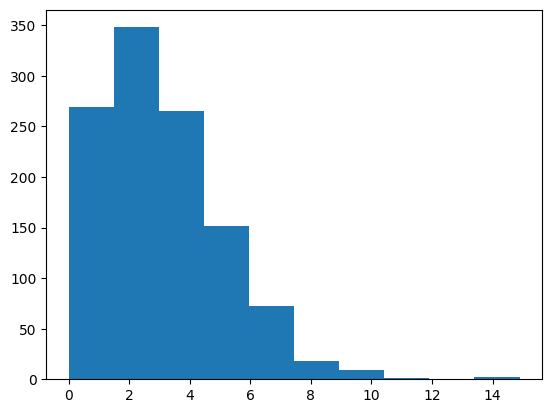

In [56]:
plt.hist(list(los_var[24].values()))

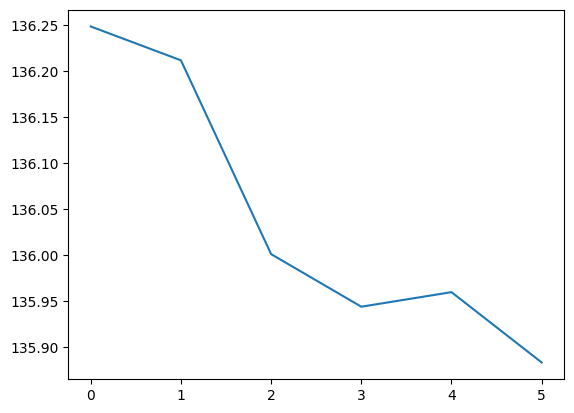

In [50]:
fig, ax = plt.subplots(1,1)
ax.plot(avg_across_stays)

In [44]:
np.array(list(abs_errors.values()))

array([[132.63166667, 132.23166667, 132.14277778, 131.58722222,
        132.13166667, 133.28166667],
       [ 50.92916667,  50.52916667,  50.42916667,  51.12916667,
         50.32916667,  50.30694444],
       [ 83.32027778,  83.85361111,  83.77027778,  83.22027778,
         83.42027778,  85.79805556],
       ...,
       [ 73.70888889,  73.60888889,  74.60888889,  75.60888889,
         73.98388889,  74.23388889],
       [ 90.98861111,  88.08861111,  88.38861111,  88.68861111,
         89.45527778,  89.88861111],
       [ 83.12805556,  83.22805556,  83.79472222,  83.42805556,
         84.12805556,  84.55662698]])

In [27]:
parse_length_of_stay(responses_dict['length_of_stay'][1][30371730])

[5.0, 2.0, 2.0, 8.0, 4.0, 4.0, 2.0, 5.0, 4.0, 4.0]